In [1]:
import os
import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error, explained_variance_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing the TaxiFarePredictor class from main.py
from main import TaxiFarePredictor

In [2]:
# Additional class for Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [3]:
# Training and evaluation class for neural network
class TaxiFarePredictorNN(TaxiFarePredictor):
    def __init__(self, file_path, n_samples=100_000, batch_size=32, epochs=10, learning_rate=0.001):
        super().__init__(file_path, n_samples)
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = NeuralNetwork().to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def load_and_preprocess_data(self):
        super().load_and_preprocess_data()
        
        # Prepare DataLoader
        features = ['day', 'hour', 'trip_duration', 'trip_distance']
        X = self.df[features].values
        y = self.df['total_amount'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(self.device)
        y_train = torch.tensor(y_train, dtype=torch.float32).to(self.device).view(-1, 1)
        y_test = torch.tensor(y_test, dtype=torch.float32).to(self.device).view(-1, 1)
        
        # Create DataLoader
        self.train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=self.batch_size, shuffle=False)
        print("Data preprocessing completed successfully!")
    
    def train_model(self):
        print("Training the model...")
        train_losses = []
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, targets in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}"):
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")
        self.plot_loss(train_losses)
        print("Model training completed successfully!")
    
    def evaluate_model(self):
        print("Evaluating the model...")
        self.model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for inputs, targets in self.test_loader:
                outputs = self.model(inputs)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())
        
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        
        mae = mean_absolute_error(actuals, predictions)
        rmse = mean_squared_error(actuals, predictions, squared=False)
        r2 = r2_score(actuals, predictions)
        mape = mean_absolute_percentage_error(actuals, predictions)
        medae = median_absolute_error(actuals, predictions)
        explained_variance = explained_variance_score(actuals, predictions)
        
        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"Mean Absolute Percentage Error: {mape:.4f}")
        print(f"Median Absolute Error: {medae:.4f}")
        print(f"Explained Variance Score: {explained_variance:.4f}")

    def plot_loss(self, losses):
        plt.figure(figsize=(10, 5))
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()

Loading data...
Data loaded successfully!
Initial shape of the data: (2964624, 5)
Dropping rows with missing values...
Shape after dropping missing values: (2964624, 5)
Removing rows with negative fare amounts...
Shape after removing negative fare amounts: (2929122, 5)
Removing outliers...
Shape after removing outliers from 'trip_distance': (2553566, 5)
Shape after removing outliers from 'total_amount': (2462875, 5)
Shape after removing outliers from 'trip_duration': (2415876, 5)
Sampling the data...
Shape after sampling: (100000, 5)
Scaling the features...
Splitting the data into training and testing sets...
Data split into training and testing sets successfully!
Generating exploratory plots...


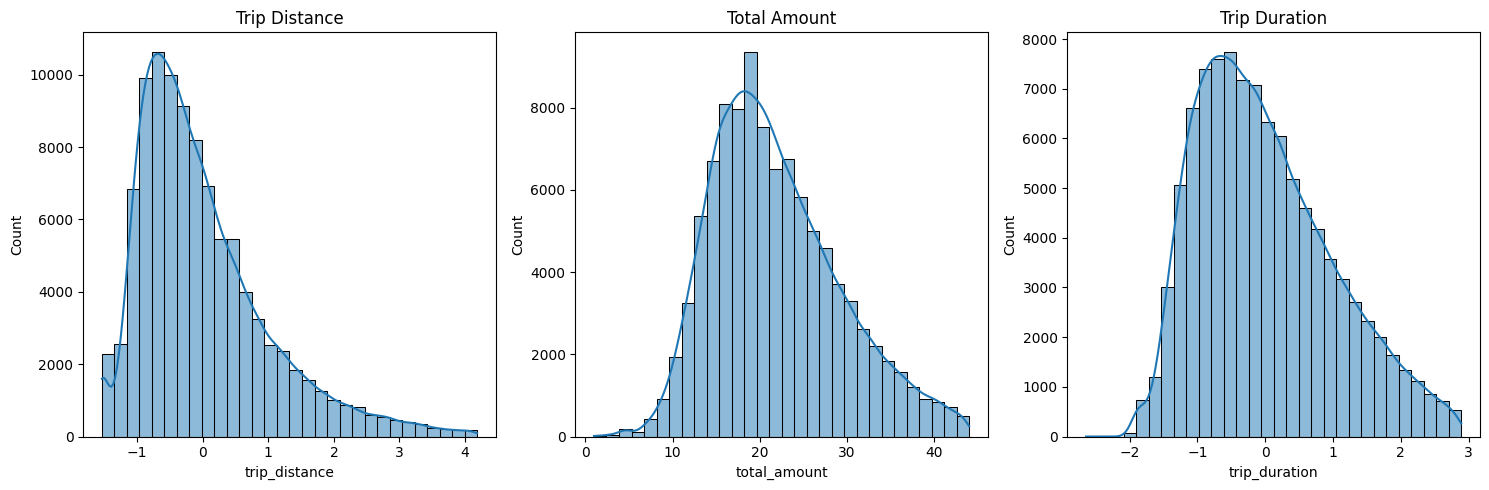

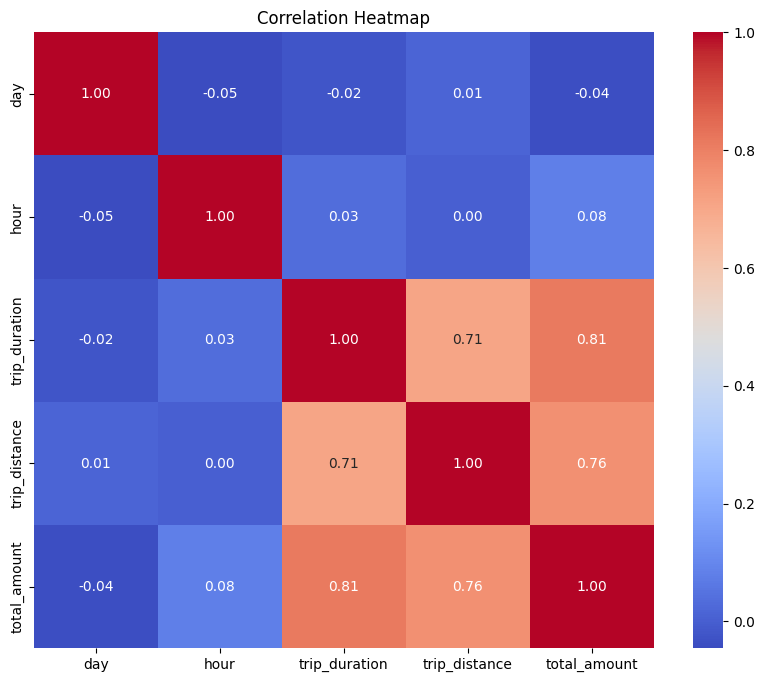

Exploratory plots generated successfully!
Data preprocessing completed successfully!
Training the model...


Epoch 1/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1/10, Loss: 25.8548


Epoch 2/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2/10, Loss: 14.0113


Epoch 3/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3/10, Loss: 13.8298


Epoch 4/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4/10, Loss: 13.7346


Epoch 5/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5/10, Loss: 13.6643


Epoch 6/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 6/10, Loss: 13.6276


Epoch 7/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 7/10, Loss: 13.6148


Epoch 8/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 8/10, Loss: 13.5596


Epoch 9/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 9/10, Loss: 13.5667


Epoch 10/10:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 10/10, Loss: 13.5436


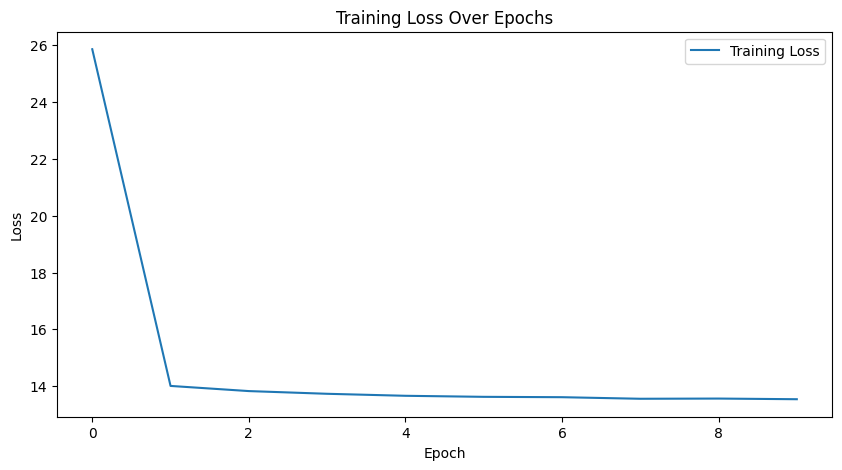

Model training completed successfully!
Evaluating the model...
Mean Absolute Error: 2.8610
Root Mean Squared Error: 3.6570
R² Score: 0.7529
Mean Absolute Percentage Error: 0.1506
Median Absolute Error: 2.3824
Explained Variance Score: 0.7543


/home/deep/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
# Main execution block
if __name__ == "__main__":
    import glob
    import os
    
    dataset_directory = 'dataset/'
    csv_files = glob.glob(os.path.join(dataset_directory, 'main.csv'))

    if not csv_files:
        print("No main.csv file found in the dataset directory.")
    else:
        csv_file_path = csv_files[0]
        predictor = TaxiFarePredictorNN(csv_file_path, n_samples=100_000, batch_size=32, epochs=10, learning_rate=0.001)
        predictor.load_and_preprocess_data()
        predictor.train_model()
        predictor.evaluate_model()